In [ ]:
# =====================================================
# Marketing Campaign Optimization using Linear Programming
# =====================================================

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from scipy.optimize import linprog

# -------------------------------
# 1. Load Dataset
# -------------------------------
df = pd.read_csv("advertising.csv")  # Make sure this file is in the same folder
print("Dataset Loaded ✅")
print(df.head(), "\n")
print(df.shape)
# Identify target and feature columns
target_col = [c for c in df.columns if c.lower() in ['sales', 'sale', 'target']][0]
feature_cols = [c for c in df.columns if c != target_col]

# -------------------------------
# 2. Train-Test Split
# -------------------------------
X = df[feature_cols].values
y = df[target_col].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# -------------------------------
# 3. Linear Regression Model
# -------------------------------
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
coeffs = dict(zip(feature_cols, lr.coef_.round(6)))
intercept = float(lr.intercept_.round(6))

print("Model trained ✅")
print(f"Intercept: {intercept}")
print(f"Coefficients: {coeffs}")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}\n")

# -------------------------------
# 4. Linear Programming Setup
# -------------------------------
B = 1_000_000  # Total advertising budget in ₹
print(f"Optimizing for total budget = {B:,}\n")

# Channel bounds (min 5% to max 80%)
bounds = [(0.05*B, 0.8*B) for _ in feature_cols]

# Objective coefficients (maximize sum(coeff_i * x_i))
# linprog minimizes → use negative coefficients
c = np.array([-coeffs[ch] for ch in feature_cols])

# Constraint: sum(x_i) ≤ B
A_ub = np.ones((1, len(feature_cols)))
b_ub = np.array([B])

# -------------------------------
# 5. Solve LP
# -------------------------------
res = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs')

if res.success:
    allocations = dict(zip(feature_cols, res.x))
    predicted_sales = sum(coeffs[ch]*allocations[ch] for ch in feature_cols) + intercept
    print("Optimization successful ✅\n")
else:
    print("Optimization failed ❌")
    allocations = {}
    predicted_sales = None

# -------------------------------
# 6. Results
# -------------------------------
alloc_df = pd.DataFrame({
    "Channel": list(allocations.keys()),
    "Allocation ()": list(allocations.values()),
    "Coefficient": [coeffs[ch] for ch in allocations.keys()]
})
alloc_df["% of Budget"] = (alloc_df["Allocation ()"] / alloc_df["Allocation ()"].sum() * 100).round(2)
alloc_df["Expected Sales Contribution"] = (alloc_df["Allocation ()"] * alloc_df["Coefficient"]).round(2)

print(alloc_df, "\n")
print(f"Predicted Total Sales ≈ {predicted_sales:.2f}\n")

# -------------------------------
# 7. Save Results
# -------------------------------
alloc_df.to_csv("optimal_allocations.csv", index=False)
print("Results saved to 'optimal_allocations.csv' ✅")


Dataset Loaded ✅
      TV  Radio  Newspaper  Sales
0  230.1   37.8       69.2   22.1
1   44.5   39.3       45.1   10.4
2   17.2   45.9       69.3   12.0
3  151.5   41.3       58.5   16.5
4  180.8   10.8       58.4   17.9 

(200, 4)
Model trained ✅
Intercept: 4.747436
Coefficients: {'TV': np.float64(0.05394), 'Radio': np.float64(0.103767), 'Newspaper': np.float64(0.002477)}
R² Score: 0.9284
RMSE: 1.5062

Optimizing for total budget = 1,000,000

Optimization successful ✅

     Channel  Allocation ()  Coefficient  % of Budget  \
0         TV       150000.0     0.053940         15.0   
1      Radio       800000.0     0.103767         80.0   
2  Newspaper        50000.0     0.002477          5.0   

   Expected Sales Contribution  
0                      8091.00  
1                     83013.60  
2                       123.85   

Predicted Total Sales ≈ 91233.20

Results saved to 'optimal_allocations.csv' ✅


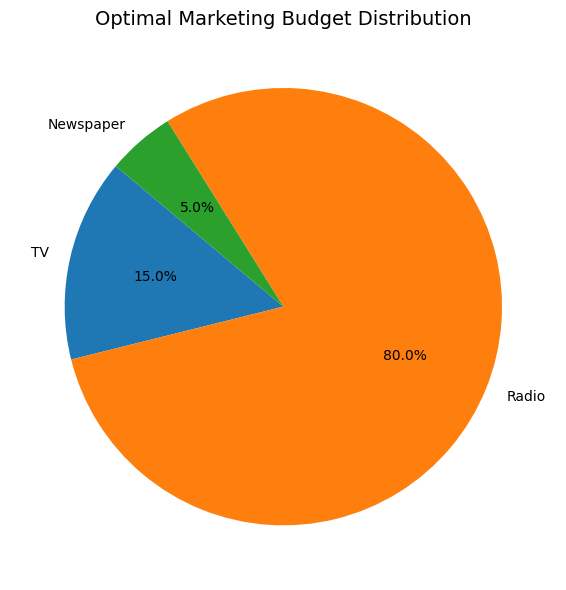

In [ ]:
import matplotlib.pyplot as plt

# --- Pie Chart for Budget Allocation ---
labels = alloc_df["Channel"]
sizes = alloc_df["Allocation ()"]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Optimal Marketing Budget Distribution", fontsize=14)
plt.tight_layout()
plt.show()


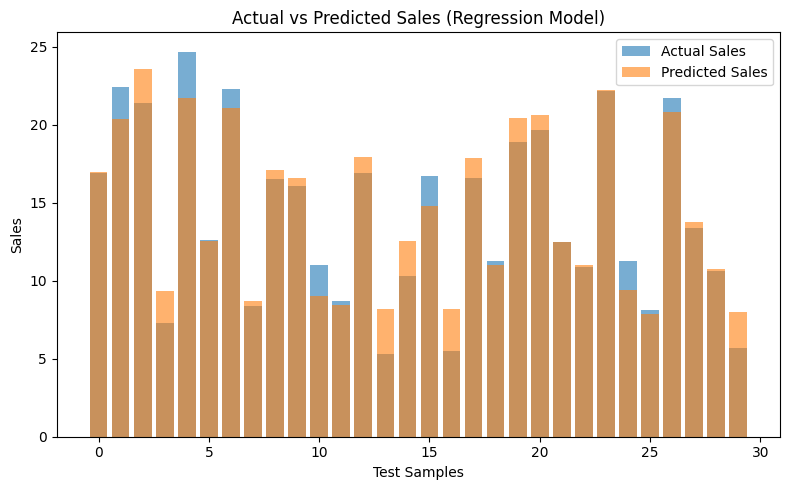

In [ ]:
# --- Actual vs Predicted Sales ---
plt.figure(figsize=(8, 5))
plt.bar(range(len(y_test)), y_test, label='Actual Sales', alpha=0.6)
plt.bar(range(len(y_pred)), y_pred, label='Predicted Sales', alpha=0.6)
plt.xlabel("Test Samples")
plt.ylabel("Sales")
plt.title("Actual vs Predicted Sales (Regression Model)")
plt.legend()
plt.tight_layout()
plt.show()


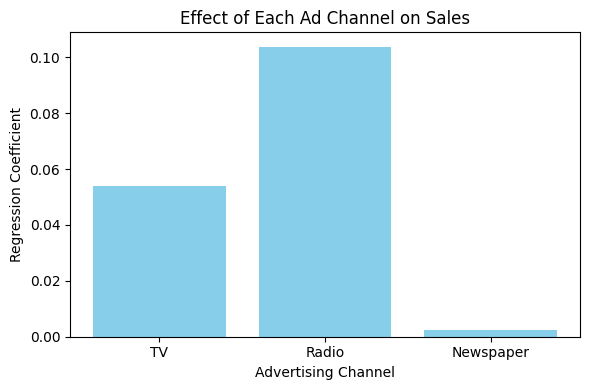

In [ ]:
# --- Feature Importance Chart ---
plt.figure(figsize=(6,4))
plt.bar(coeffs.keys(), coeffs.values(), color='skyblue')
plt.title("Effect of Each Ad Channel on Sales")
plt.xlabel("Advertising Channel")
plt.ylabel("Regression Coefficient")
plt.tight_layout()
plt.show()
